In [1]:
#Essential Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset

dataset = pd.read_csv('Thyroid_Diff.csv')
df = dataset

# Data Preprocessing
    # finding Correlation
le = LabelEncoder()
df_encoded = df.apply(lambda col: le.fit_transform(col) if col.dtypes == 'object' else col)
correlations = df_encoded.corr()['Recurred'].drop('Recurred').sort_values(ascending=False)

    # Selecting columns with low correlation
columns_to_drop = [
    'Hx Radiothreapy',
    'Hx Smoking',
    'Thyroid Function',
    'Pathology',
    'Physical Examination',
    'Adenopathy'
]
    # Dropping columns with low correlation
df_cleaned = df.drop(columns=columns_to_drop)
X= df_cleaned.iloc[:, :-1]
y= df_cleaned.iloc[:, -1].values

    # Encoding categorical variables
y = le.fit_transform(y)

columns = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), columns)], remainder='passthrough')
X_encoded = ct.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train[:,-1] = scaler.fit_transform(X_train[:,-1].reshape(-1, 1))
X_test[:,-1] = scaler.transform(X_test[:,-1].reshape(-1, 1))


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': list(range(100, 500, 100))}
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print("Best n_estimators:", grid_search.best_params_['n_estimators'])
k= grid_search.best_params_['n_estimators']


classifier = RandomForestClassifier(n_estimators = k, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)





RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=0)

C:\Users\karth\AppData\Local\Temp\ipykernel_33184\1630212138.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


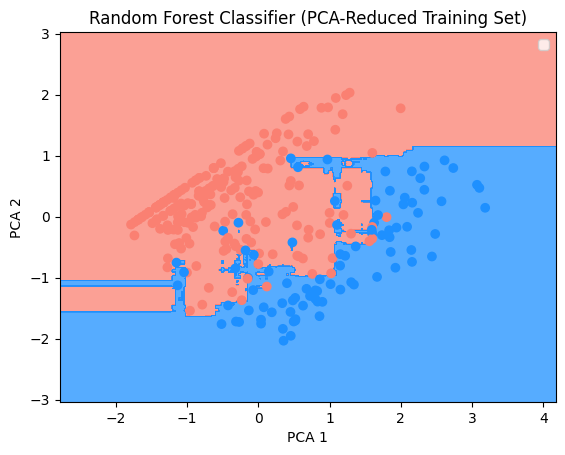

In [5]:
from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit model on 2D data (just for plotting)
classifier_pca = RandomForestClassifier(n_estimators=k, criterion='entropy', random_state=0)
classifier_pca.fit(X_train_pca, y_train)

# Now plot using X_train_pca
X_set, y_set = X_train_pca, y_train
X1, X2 = np.meshgrid(np.arange(X_set[:, 0].min() - 1, X_set[:, 0].max() + 1, 0.01),
                     np.arange(X_set[:, 1].min() - 1, X_set[:, 1].max() + 1, 0.01))

plt.contourf(X1, X2, classifier_pca.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(['#FA8072', '#1E90FF']))
plt.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap=ListedColormap(['#FA8072', '#1E90FF']))
plt.title('Random Forest Classifier (PCA-Reduced Training Set)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


C:\Users\karth\AppData\Local\Temp\ipykernel_33184\1754312817.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


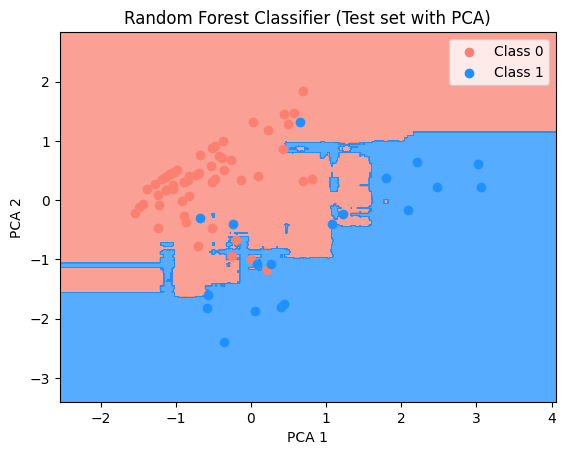

In [6]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier on 2D PCA data just for plotting
classifier_pca = RandomForestClassifier(n_estimators=k, criterion='entropy', random_state=0)
classifier_pca.fit(X_train_pca, y_train)

# Visualization for Test Set
X_set, y_set = X_test_pca, y_test
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01)
)
Z = classifier_pca.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(['#FA8072', '#1E90FF']))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Scatter test points
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(['#FA8072', '#1E90FF'])(i), label=f'Class {j}')
    
plt.title('Random Forest Classifier (Test set with PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [8]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print('accuracy_score:', accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[58  0]
 [ 1 18]]
accuracy_score: 0.987012987012987


In [7]:
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.95      0.97        19

    accuracy                           0.99        77
   macro avg       0.99      0.97      0.98        77
weighted avg       0.99      0.99      0.99        77

